In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import h5py
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Here we are importing the h5 file and create a dataframe.

In [2]:
file = h5py.File('Data_Fuchs_v_2.7_Wright_Pat_Narrow_Range_energy_limit_0.01_deviation_0.9_lambda_um_0.8_points_100000_seed_6991.h5','r')
file_dict = dict()
for i in file.keys():
    file_dict[i] = file[i][:]
file.close()
physics = pd.DataFrame(file_dict)

# Here we specify the input and output variables

In [3]:
outputs = ['Max_Proton_Energy_(MeV)', 'Total_Proton_Energy_(MeV)', 'Avg_Proton_Energy_(MeV)']

In [4]:
# this is to avoid copying a pasting
inputs = []
for i in physics.columns:
    if i in outputs:
        continue
    else:
        inputs.append(i)
inputs

['Intensity_(W_cm2)',
 'Pulse_Duration_(fs)',
 'Spot_Size_(FWHM um)',
 'Target_Thickness (um)']

##### For now, we will work with a dataframe that only has Max Proton Energy as the output variable and name it df.

In [5]:
df = physics.copy()
df = df.drop(columns= outputs[1:])
df.columns

Index(['Intensity_(W_cm2)', 'Max_Proton_Energy_(MeV)', 'Pulse_Duration_(fs)',
       'Spot_Size_(FWHM um)', 'Target_Thickness (um)'],
      dtype='object')

##### The rows that contain negative Max Proton Energy will be dropped.

In [6]:
df = df[df[outputs[0]] > 0]

##### The train and split sets will also be created here for df.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df[[inputs[0], inputs[3]]], df[outputs[0]], test_size=0.33, random_state=0)

##### Normalizing the data

In [8]:
X_train_means = X_train.mean()
X_train_stds = X_train.std(ddof=1)
X_train_norm = (X_train - X_train_means) / X_train_stds

y_train_means = y_train.mean()
y_train_stds = y_train.std(ddof=1)
y_train_norm = (y_train - y_train_means) / y_train_stds

X_test_means = X_test.mean()
X_test_stds = X_test.std(ddof=1)
X_test_norm = (X_test - X_test_means) / X_test_stds

y_test_means = y_test.mean()
y_test_stds = y_test.std(ddof=1)
y_test_norm = (y_test - y_test_means) / y_test_stds

In [9]:
X_train_norm.head()

,Intensity_(W_cm2),Target_Thickness (um)
42922,-1.333915,-0.219328
41691,-1.217032,-0.185452
51047,0.140638,-1.703490
78845,-1.012804,1.117538
28030,-0.149518,1.419748


# Scatter plot of the data to be modeled.

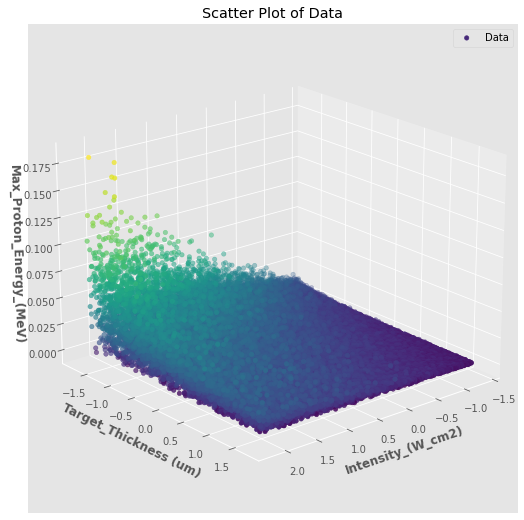

In [10]:
fig1 = plt.figure(figsize=(9, 9))
ax = fig1.add_subplot(projection='3d')
ax.scatter(X_train_norm[inputs[0]],
           X_train_norm[inputs[3]],
           y_train,
           c = np.sqrt(y_train),
           label = "Data")
ax.set_title('Scatter Plot of Data')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(20, 50)
plt.legend(loc="upper right")
plt.show()

# Support Vector Regression model (SVR)

##### First we create a model to predict the values of the X test set to see what the predictions look like.

In [11]:
start_time = time.process_time()

In [12]:
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.03, coef0=.5)

In [13]:
svr_poly.fit(X_train_norm[[inputs[0], inputs[3]]], np.log(y_train))

SVR(C=100, coef0=0.5, epsilon=0.03, gamma='auto', kernel='poly')

In [14]:
np.exp(svr_poly.predict(X_train_norm))

array([0.00128729, 0.00147824, 0.0220065 , ..., 0.00077773, 0.00184011,
       0.01002935])

##### CPU time to run, train, and predict data

In [15]:
end_time = time.process_time()
print(f'The CPU time for this model to run is {end_time - start_time} seconds.')
del start_time
del end_time

The CPU time for this model to run is 726.0935639999999 seconds.


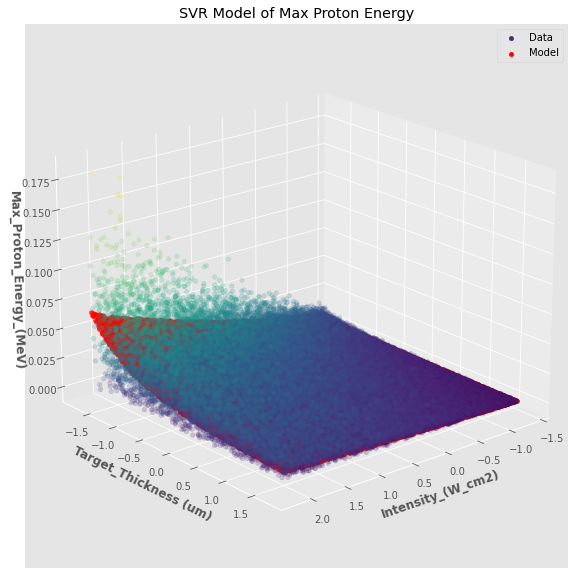

In [16]:
fig2 = plt.figure(figsize=(10, 10))
ax = fig2.add_subplot(projection='3d')
ax.scatter(X_train_norm[inputs[0]],
           X_train_norm[inputs[3]],
           y_train ,
           c = np.sqrt(y_train),
           alpha = .2,
           label= 'Data')
ax.scatter(X_train_norm[inputs[0]],
           X_train_norm[inputs[3]],
           np.exp(svr_poly.predict(X_train_norm)),
           c = 'red',
           alpha= .6,
           label= 'Model')
ax.set_title('SVR Model of Max Proton Energy')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(20, 50)
plt.legend(loc="upper right")
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_alpha(1)
leg.legendHandles[0].set_alpha(1)
plt.show()

##### An error dataframe will be created for the log transformed data model for the testing sets. This dataframe will also contain the predicted values of the log model, and it will contain the predicted values of the model converted back into its original non log format.

In [17]:
error_3d = X_test_norm.copy()
error_3d['Predictions'] = np.exp(svr_poly.predict(X_test_norm))
error_3d['Relative Error'] = np.abs((y_test - error_3d['Predictions']) / y_test) * 100

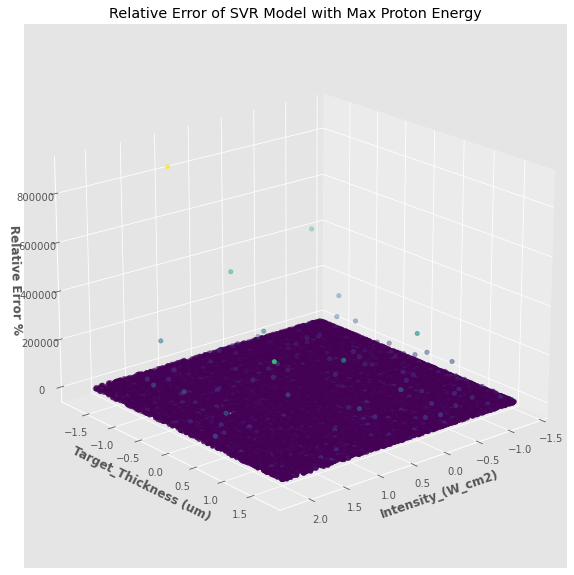

In [18]:
fig3 = plt.figure(figsize=(10, 10))
ax = fig3.add_subplot(projection='3d')
ax.scatter(X_test_norm[inputs[0]],
           X_test_norm[inputs[3]],
           error_3d['Relative Error'],
           c = np.sqrt(error_3d['Relative Error']))
ax.set_title('Relative Error of SVR Model with Max Proton Energy')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'Relative Error %', fontweight ='bold')
ax.view_init(20, 50)
plt.show()

In [19]:
mean_squared_error(y_test, error_3d['Predictions'])

4.622381272751858e-05

# Removing the mild and extreme outliers

In [22]:
error_3d_2 = error_3d.copy()
q1 = np.percentile(error_3d_2['Relative Error'], 25)
q3 = np.percentile(error_3d_2['Relative Error'], 75)
iqr = q3 - q1
error_3d_2 = error_3d_2[(error_3d_2['Relative Error'] >= q1 - 1.5 * iqr) & (error_3d_2['Relative Error'] <= q1 + 1.5 * iqr)]

In [23]:
error_3d_2

,Intensity_(W_cm2),Target_Thickness (um),Predictions,Relative Error
61061,1.026638,-0.938309,0.016813,49.183314
77055,1.344505,0.551823,0.007198,13.160901
64287,1.094482,1.196566,0.004774,12.279150
49816,0.319640,-0.731020,0.009523,3.315332
71249,-1.149386,-1.562160,0.005347,11.304811
...,...,...,...,...
86616,1.687090,0.540937,0.008414,23.368699
4442,-1.111974,0.017856,0.001489,52.630181
60889,0.710165,1.456307,0.003517,3.608996
25450,0.158909,1.252871,0.002712,68.397776


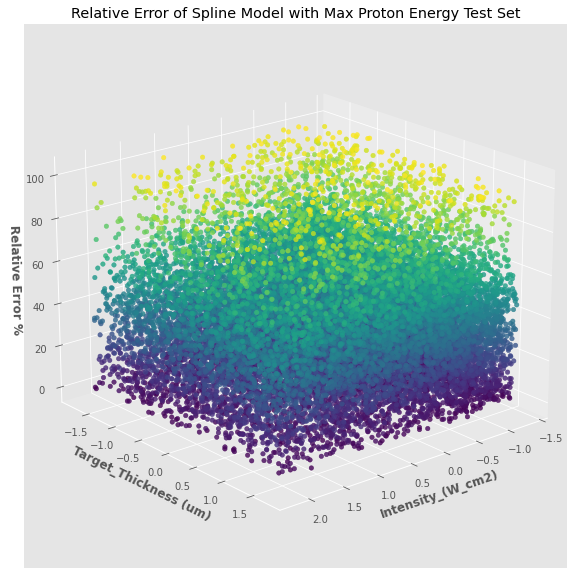

In [24]:
fig5 = plt.figure(figsize=(10, 10))
ax = fig5.add_subplot(projection='3d')
ax.scatter(error_3d_2[inputs[0]],
           error_3d_2[inputs[3]],
           error_3d_2['Relative Error'],
           alpha = .8,
           c = error_3d_2['Relative Error'])
ax.set_title('Relative Error of Spline Model with Max Proton Energy Test Set')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'Relative Error %', fontweight ='bold')
ax.view_init(20, 50)
plt.show()